In [14]:
from relic.graphs.graphs import get_precision_recall #, draw_graph
import pandas as pd
import networkx as nx
import os
import glob

import numpy as np
import pickle
import seaborn as sns
import logging
from tqdm.auto import tqdm




In [15]:
base_dir = '/Users/suhail/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/'

In [16]:
def result_dict_to_df(result_dict, nb_name='nb', result_type='relic', 
                      alpha=0.0, beta=0.0, gamma=0.0):
    result_dict.update({'nb_name': nb_name, 
                       'result_type': result_type,
                       'alpha' : alpha,
                       'beta': beta,
                       'gamma': gamma})
    return pd.DataFrame({k: [v] for k, v in result_dict.items()})


def process_directory(base_dir, base_score_file="cell_sim.pkl", score_type='cell', sample_score_file="ppo.csv"):
    all_results = []
    all_gt_graphs = {}
    edges_df = pd.DataFrame()
    relic_result_df = list()
    #columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    #columns = ['nb_name', 'src', 'dst', score_type, 'sampling', 'index']
    
    #print(workflow_ids)
    alphas = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    for alpha in tqdm(alphas):
        a_base_dir = f"{base_dir}/{alpha}"
        betas = sorted([d for d in os.listdir(a_base_dir) if os.path.isdir(os.path.join(a_base_dir, d))])
        for beta in tqdm(betas):
            b_base_dir = f"{a_base_dir}/{beta}"
            gammas = sorted([d for d in os.listdir(b_base_dir) if os.path.isdir(os.path.join(b_base_dir, d))])
            for gamma in tqdm(gammas):
                g_base_dir = f"{b_base_dir}/{gamma}"
                workflow_ids = [d for d in os.listdir(g_base_dir) if os.path.isdir(os.path.join(g_base_dir, d))]
                for i in tqdm(workflow_ids):
                    try:
                        gt_file = f"{g_base_dir}/{i}/{i}_gt_fixed.pkl"
                        gt_graph = nx.read_gpickle(gt_file)
                        all_gt_graphs[i] = gt_graph
                        all_results.append(gt_graph)
                        inferred_dir = f"{g_base_dir}/{i}/inferred/"
                                    # Load Relic Result graph and compute P/R/F1
                        relic_graph_file = f"{inferred_dir}/relic_inferred_graph.csv"
                        relic_graph_result = nx.read_edgelist(relic_graph_file)
                        result_dict = get_precision_recall(gt_graph, relic_graph_result)
                        relic_result_df.append(result_dict_to_df(result_dict,
                                                                  nb_name=i,
                                                                  alpha=alpha,
                                                                  beta=beta,
                                                                  gamma=gamma))
                    except FileNotFoundError as e:
                        pass
            break
        break
    
                        
                        
    return pd.concat(relic_result_df, ignore_index=True)

In [59]:
def process_specific_directories(workload_list, base_score_file="cell_sim.pkl", score_type='cell', sample_score_file="ppo.csv"):
    all_results = []
    all_gt_graphs = {}
    edges_df = pd.DataFrame()
    relic_result_df = list()
    #columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    #columns = ['nb_name', 'src', 'dst', score_type, 'sampling', 'index']

    #print(workflow_ids)
    for full_path in tqdm(workload_list):
        path_comps = full_path.split('/')
        path_comps.reverse()
        alpha, beta, gamma, i = path_comps[3], path_comps[2], path_comps[1], path_comps[0]
        #print(path_comps)
        try:
            gt_file = f"{full_path}/{i}_gt_fixed.pkl"
            gt_graph = nx.read_gpickle(gt_file)
            all_gt_graphs[i] = gt_graph
            all_results.append(gt_graph)
            inferred_dir = f"{full_path}/inferred/"
            # Load Non SM graph and compute P/R/F1
            relic_graph_file = f"{inferred_dir}/relic_inferred_graph.csv"
            relic_graph_result = nx.read_edgelist(relic_graph_file)
            result_dict = get_precision_recall(gt_graph, relic_graph_result)
            relic_result_df.append(result_dict_to_df(result_dict,
                                                     result_type='relic_sm',
                                                     nb_name=i,
                                                     alpha=alpha,
                                                     beta=beta,
                                                     gamma=gamma))


            relic_graph_file = f"{inferred_dir}/relicnsm_inferred_graph.csv"
            relic_graph_result = nx.read_edgelist(relic_graph_file)
            result_dict = get_precision_recall(gt_graph, relic_graph_result)
            relic_result_df.append(result_dict_to_df(result_dict,
                                                     result_type='relic_nsm',
                                                     nb_name=i,
                                                     alpha=alpha,
                                                     beta=beta,
                                                     gamma=gamma))


        except FileNotFoundError as e:
            pass



    return pd.concat(relic_result_df, ignore_index=True)

In [60]:
remote_path_prefix = '/tank/local/suhail'
local_path_prefix = '/mnt/roscoe'

with open('../scripts/workload.txt', 'r') as fp:
    dir_list = fp.readlines()
    #dir_list = ['/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-154011']
    dir_list = [x.strip().replace(remote_path_prefix, local_path_prefix) for x in dir_list]

    
dir_list = ['/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.3/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.3/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.3/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.3/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.3/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.4/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.4/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.4/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.4/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.4/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.5/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.5/0.5/20210126-155620'
]

dir_list

['/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-155620',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-183630',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-171602',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181345',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-181822',
 '/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-1

In [61]:
r_df = process_specific_directories(dir_list)
r_df

  0%|          | 0/27 [00:00<?, ?it/s]

,Precision,Recall,F1,correct_edges,to_add,to_remove,nb_name,result_type,alpha,beta,gamma
0,0.755102,0.755102,0.755102,"{(29.csv, 13.csv), (0.csv, 1.csv), (4.csv, 6.c...","{(14.csv, 17.csv), (41.csv, 42.csv), (16.csv, ...","{(35.csv, 48.csv), (45.csv, 48.csv), (23.csv, ...",20210126-181822,relic_sm,0.1,0.1,0.3
1,0.673469,0.673469,0.673469,"{(0.csv, 1.csv), (4.csv, 6.csv), (29.csv, 34.c...","{(14.csv, 17.csv), (29.csv, 13.csv), (36.csv, ...","{(35.csv, 48.csv), (45.csv, 48.csv), (27.csv, ...",20210126-181822,relic_nsm,0.1,0.1,0.3
2,0.894737,0.894737,0.894737,"{(14.csv, 17.csv), (0.csv, 1.csv), (18.csv, 14...","{(19.csv, 18.csv), (16.csv, 5.csv)}","{(16.csv, 6.csv), (9.csv, 19.csv)}",20210126-155620,relic_sm,0.1,0.1,0.3
3,0.894737,0.894737,0.894737,"{(14.csv, 17.csv), (0.csv, 1.csv), (18.csv, 14...","{(19.csv, 18.csv), (16.csv, 5.csv)}","{(16.csv, 6.csv), (9.csv, 19.csv)}",20210126-155620,relic_nsm,0.1,0.1,0.3
4,0.714286,0.714286,0.714286,"{(9.csv, 11.csv), (30.csv, 36.csv), (47.csv, 4...","{(38.csv, 27.csv), (0.csv, 1.csv), (21.csv, 18...","{(10.csv, 7.csv), (7.csv, 12.csv), (39.csv, 26...",20210126-183630,relic_sm,0.1,0.1,0.3
5,0.693878,0.693878,0.693878,"{(9.csv, 11.csv), (30.csv, 36.csv), (47.csv, 4...","{(0.csv, 1.csv), (13.csv, 6.csv), (43.csv, 40....","{(30.csv, 39.csv), (10.csv, 7.csv), (7.csv, 12...",20210126-183630,relic_nsm,0.1,0.1,0.3
6,0.673469,0.673469,0.673469,"{(15.csv, 14.csv), (27.csv, 22.csv), (33.csv, ...","{(8.csv, 7.csv), (32.csv, 6.csv), (8.csv, 1.cs...","{(45.csv, 48.csv), (9.csv, 13.csv), (4.csv, 18...",20210126-171602,relic_sm,0.1,0.1,0.3
7,0.673469,0.673469,0.673469,"{(15.csv, 14.csv), (27.csv, 22.csv), (33.csv, ...","{(8.csv, 7.csv), (32.csv, 6.csv), (8.csv, 1.cs...","{(45.csv, 48.csv), (9.csv, 13.csv), (4.csv, 18...",20210126-171602,relic_nsm,0.1,0.1,0.3
8,0.860465,0.755102,0.804348,"{(0.csv, 1.csv), (33.csv, 35.csv), (8.csv, 6.c...","{(25.csv, 15.csv), (24.csv, 17.csv), (30.csv, ...","{(5.csv, 31.csv), (38.csv, 42.csv), (5.csv, 0....",20210126-181345,relic_sm,0.1,0.1,0.3
9,0.723404,0.693878,0.708333,"{(0.csv, 1.csv), (33.csv, 35.csv), (8.csv, 6.c...","{(7.csv, 12.csv), (33.csv, 30.csv), (25.csv, 1...","{(5.csv, 31.csv), (18.csv, 31.csv), (22.csv, 2...",20210126-181345,relic_nsm,0.1,0.1,0.3


In [62]:
#r_df.loc[r_df.alpha != 0, "result_type"] = "relic_sm"
#r_df.loc[r_df.alpha == 0, "result_type"] = "relic_nsm"
r_df

,Precision,Recall,F1,correct_edges,to_add,to_remove,nb_name,result_type,alpha,beta,gamma
0,0.755102,0.755102,0.755102,"{(29.csv, 13.csv), (0.csv, 1.csv), (4.csv, 6.c...","{(14.csv, 17.csv), (41.csv, 42.csv), (16.csv, ...","{(35.csv, 48.csv), (45.csv, 48.csv), (23.csv, ...",20210126-181822,relic_sm,0.1,0.1,0.3
1,0.673469,0.673469,0.673469,"{(0.csv, 1.csv), (4.csv, 6.csv), (29.csv, 34.c...","{(14.csv, 17.csv), (29.csv, 13.csv), (36.csv, ...","{(35.csv, 48.csv), (45.csv, 48.csv), (27.csv, ...",20210126-181822,relic_nsm,0.1,0.1,0.3
2,0.894737,0.894737,0.894737,"{(14.csv, 17.csv), (0.csv, 1.csv), (18.csv, 14...","{(19.csv, 18.csv), (16.csv, 5.csv)}","{(16.csv, 6.csv), (9.csv, 19.csv)}",20210126-155620,relic_sm,0.1,0.1,0.3
3,0.894737,0.894737,0.894737,"{(14.csv, 17.csv), (0.csv, 1.csv), (18.csv, 14...","{(19.csv, 18.csv), (16.csv, 5.csv)}","{(16.csv, 6.csv), (9.csv, 19.csv)}",20210126-155620,relic_nsm,0.1,0.1,0.3
4,0.714286,0.714286,0.714286,"{(9.csv, 11.csv), (30.csv, 36.csv), (47.csv, 4...","{(38.csv, 27.csv), (0.csv, 1.csv), (21.csv, 18...","{(10.csv, 7.csv), (7.csv, 12.csv), (39.csv, 26...",20210126-183630,relic_sm,0.1,0.1,0.3
5,0.693878,0.693878,0.693878,"{(9.csv, 11.csv), (30.csv, 36.csv), (47.csv, 4...","{(0.csv, 1.csv), (13.csv, 6.csv), (43.csv, 40....","{(30.csv, 39.csv), (10.csv, 7.csv), (7.csv, 12...",20210126-183630,relic_nsm,0.1,0.1,0.3
6,0.673469,0.673469,0.673469,"{(15.csv, 14.csv), (27.csv, 22.csv), (33.csv, ...","{(8.csv, 7.csv), (32.csv, 6.csv), (8.csv, 1.cs...","{(45.csv, 48.csv), (9.csv, 13.csv), (4.csv, 18...",20210126-171602,relic_sm,0.1,0.1,0.3
7,0.673469,0.673469,0.673469,"{(15.csv, 14.csv), (27.csv, 22.csv), (33.csv, ...","{(8.csv, 7.csv), (32.csv, 6.csv), (8.csv, 1.cs...","{(45.csv, 48.csv), (9.csv, 13.csv), (4.csv, 18...",20210126-171602,relic_nsm,0.1,0.1,0.3
8,0.860465,0.755102,0.804348,"{(0.csv, 1.csv), (33.csv, 35.csv), (8.csv, 6.c...","{(25.csv, 15.csv), (24.csv, 17.csv), (30.csv, ...","{(5.csv, 31.csv), (38.csv, 42.csv), (5.csv, 0....",20210126-181345,relic_sm,0.1,0.1,0.3
9,0.723404,0.693878,0.708333,"{(0.csv, 1.csv), (33.csv, 35.csv), (8.csv, 6.c...","{(7.csv, 12.csv), (33.csv, 30.csv), (25.csv, 1...","{(5.csv, 31.csv), (18.csv, 31.csv), (22.csv, 2...",20210126-181345,relic_nsm,0.1,0.1,0.3


In [63]:
original_results = []
for nb in set(r_df.nb_name.values):
    or_df = pd.read_csv(f'/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/{nb}/pc2cell+containment+group+join+pivot_relic_result.csv', index_col=0)
    original_results.append(or_df.iloc[-1:])

original_df = pd.concat(original_results, ignore_index=True)[['nb_name', 'F1']]
original_df['result_type'] = 'relic_original'
original_df['alpha'] = 0
original_df['beta'] = 0
original_df['gamma'] = 0
original_df

,nb_name,F1,result_type,alpha,beta,gamma
0,20210126-171602,0.907216,relic_original,0,0,0
1,20210126-155620,0.947368,relic_original,0,0,0
2,20210126-183630,0.824742,relic_original,0,0,0
3,20210126-181822,0.897959,relic_original,0,0,0
4,20210126-181345,0.927835,relic_original,0,0,0


In [64]:
perturbed = r_df[['nb_name', 'F1', 'result_type', 'alpha', 'beta', 'gamma']].copy()
perturbed

,nb_name,F1,result_type,alpha,beta,gamma
0,20210126-181822,0.755102,relic_sm,0.1,0.1,0.3
1,20210126-181822,0.673469,relic_nsm,0.1,0.1,0.3
2,20210126-155620,0.894737,relic_sm,0.1,0.1,0.3
3,20210126-155620,0.894737,relic_nsm,0.1,0.1,0.3
4,20210126-183630,0.714286,relic_sm,0.1,0.1,0.3
5,20210126-183630,0.693878,relic_nsm,0.1,0.1,0.3
6,20210126-171602,0.673469,relic_sm,0.1,0.1,0.3
7,20210126-171602,0.673469,relic_nsm,0.1,0.1,0.3
8,20210126-181345,0.804348,relic_sm,0.1,0.1,0.3
9,20210126-181345,0.708333,relic_nsm,0.1,0.1,0.3


In [65]:
combined = pd.concat([perturbed, original_df], ignore_index=True)
combined['config'] = combined['alpha'].astype(str) +','+combined['beta'].astype(str) +','+ combined['gamma'].astype(str)

In [66]:
combined

,nb_name,F1,result_type,alpha,beta,gamma,config
0,20210126-181822,0.755102,relic_sm,0.1,0.1,0.3,"0.1,0.1,0.3"
1,20210126-181822,0.673469,relic_nsm,0.1,0.1,0.3,"0.1,0.1,0.3"
2,20210126-155620,0.894737,relic_sm,0.1,0.1,0.3,"0.1,0.1,0.3"
3,20210126-155620,0.894737,relic_nsm,0.1,0.1,0.3,"0.1,0.1,0.3"
4,20210126-183630,0.714286,relic_sm,0.1,0.1,0.3,"0.1,0.1,0.3"
5,20210126-183630,0.693878,relic_nsm,0.1,0.1,0.3,"0.1,0.1,0.3"
6,20210126-171602,0.673469,relic_sm,0.1,0.1,0.3,"0.1,0.1,0.3"
7,20210126-171602,0.673469,relic_nsm,0.1,0.1,0.3,"0.1,0.1,0.3"
8,20210126-181345,0.804348,relic_sm,0.1,0.1,0.3,"0.1,0.1,0.3"
9,20210126-181345,0.708333,relic_nsm,0.1,0.1,0.3,"0.1,0.1,0.3"


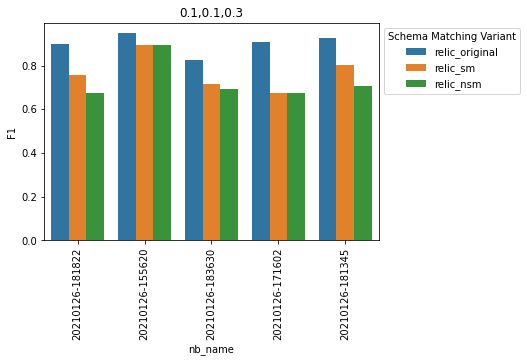

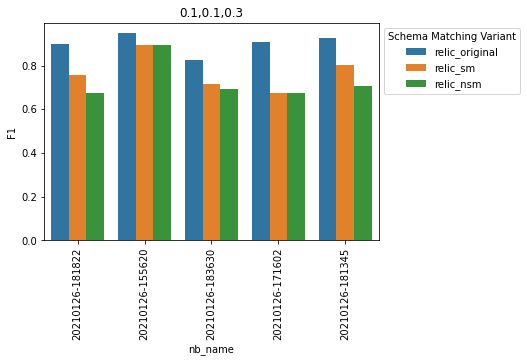

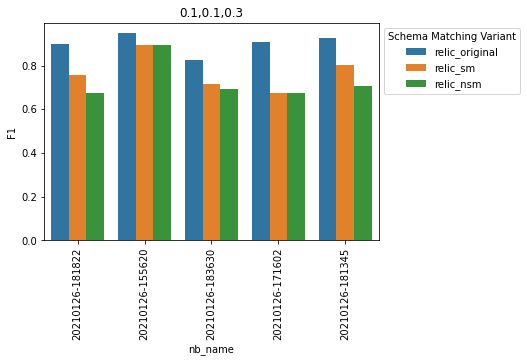

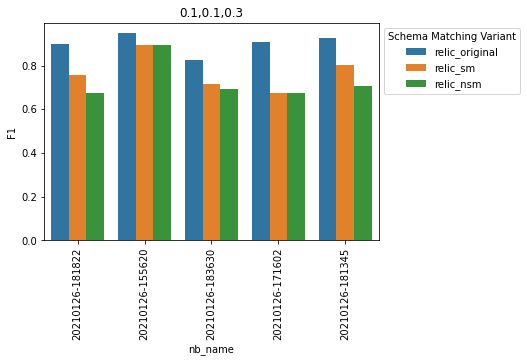

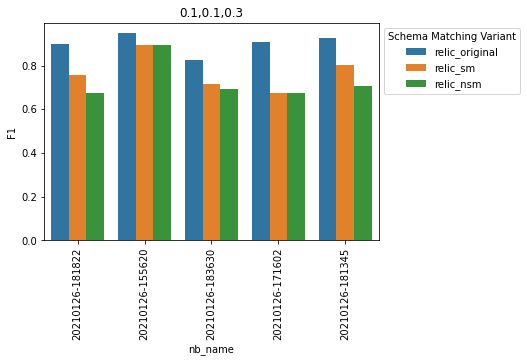

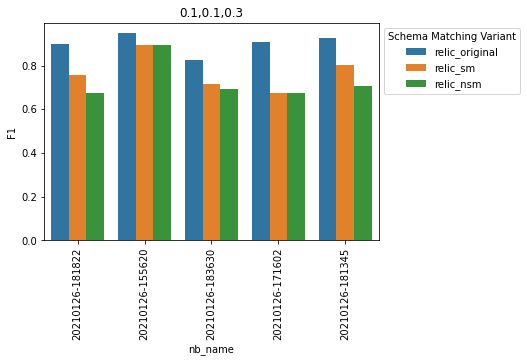

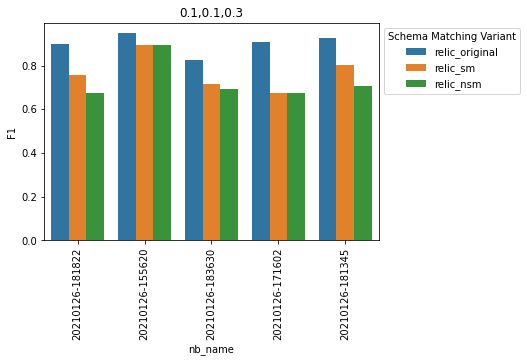

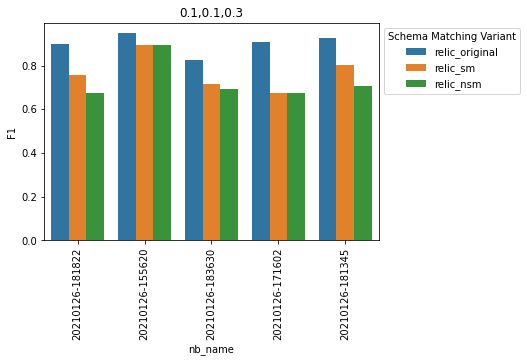

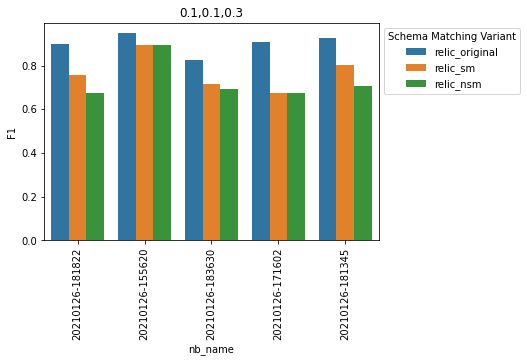

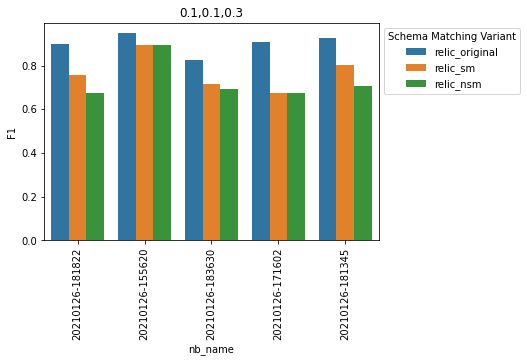

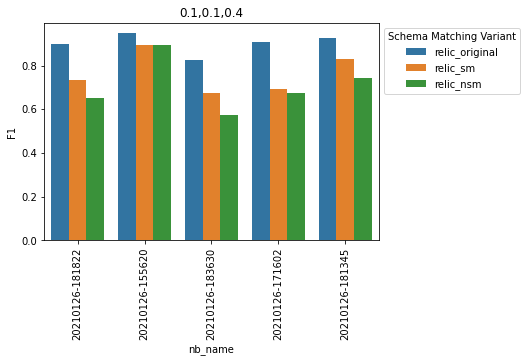

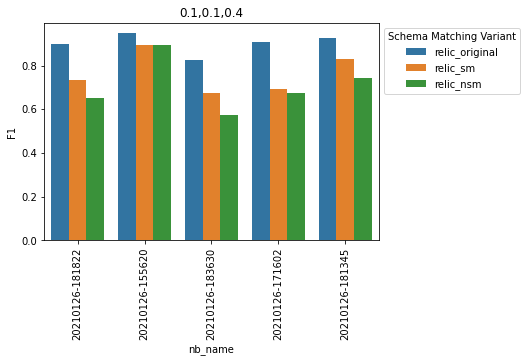

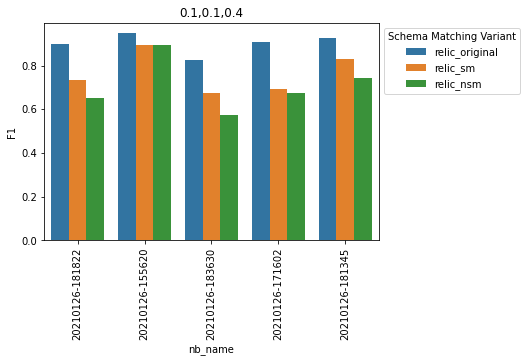

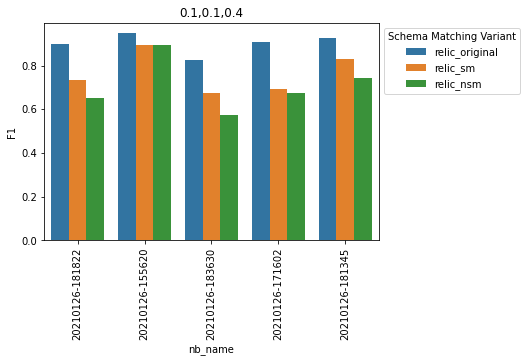

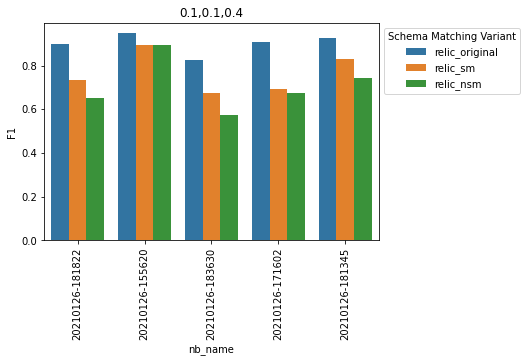

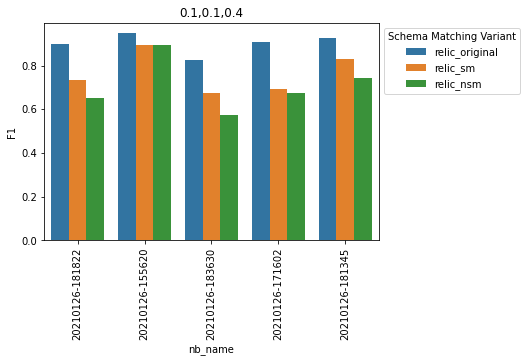

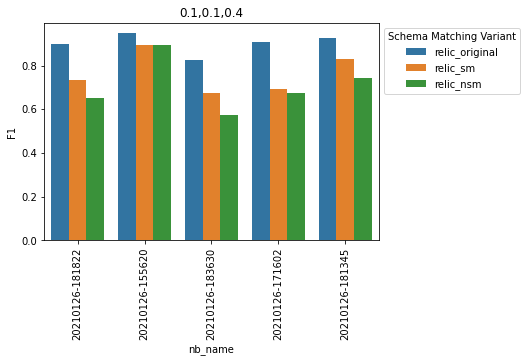

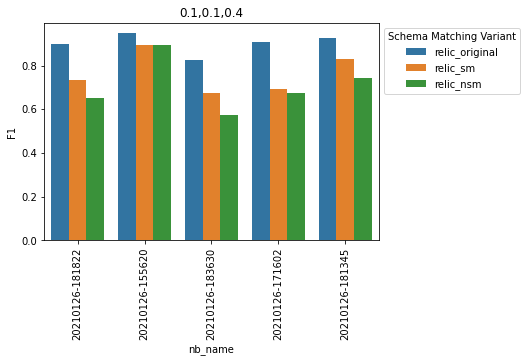

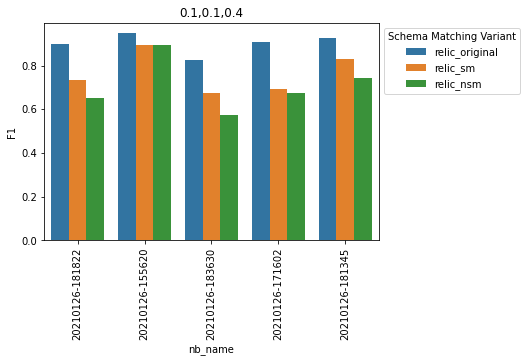

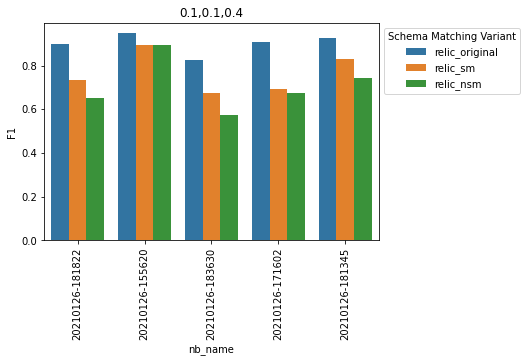

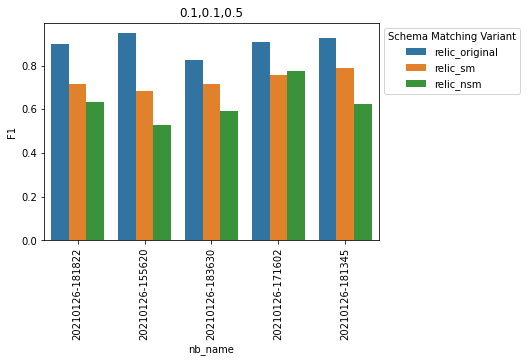

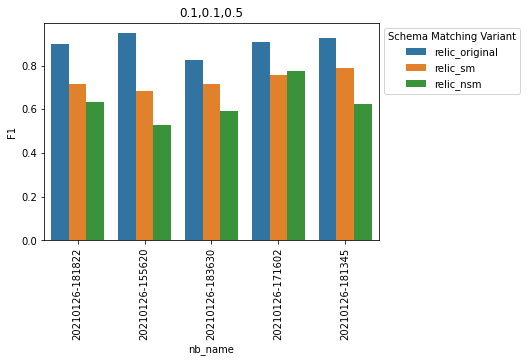

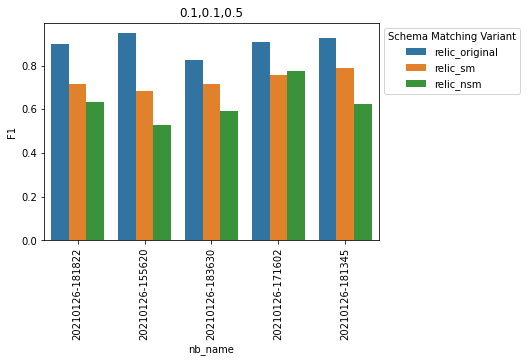

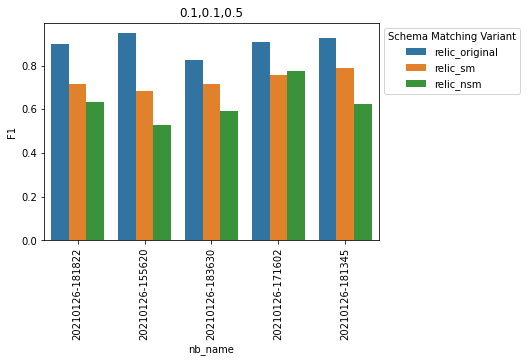

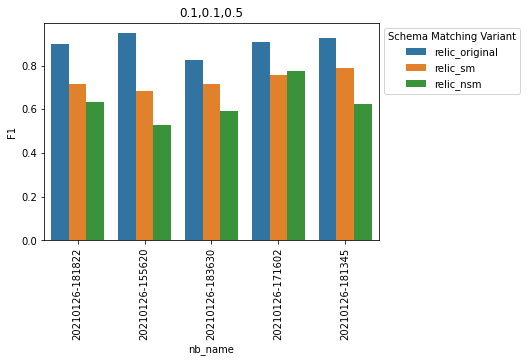

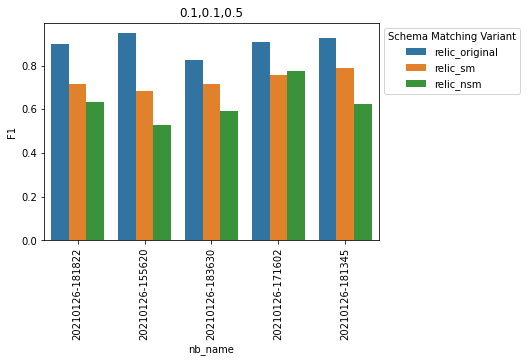

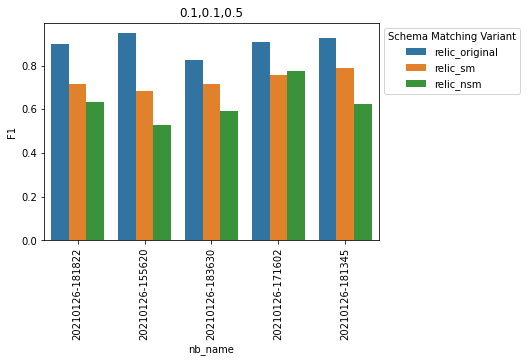

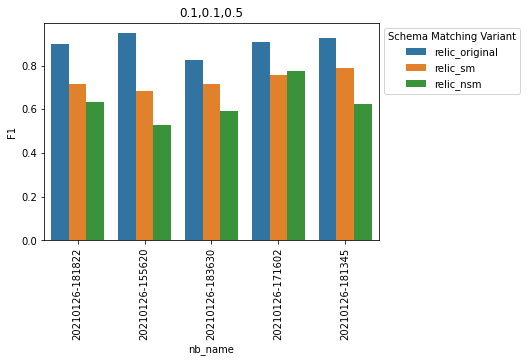

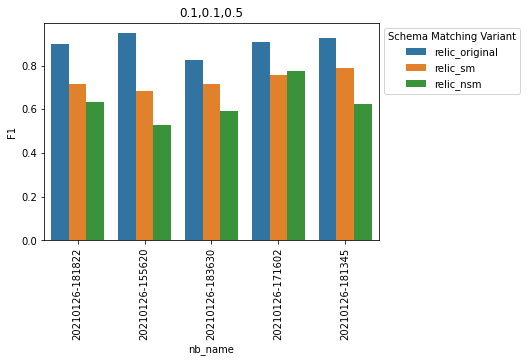

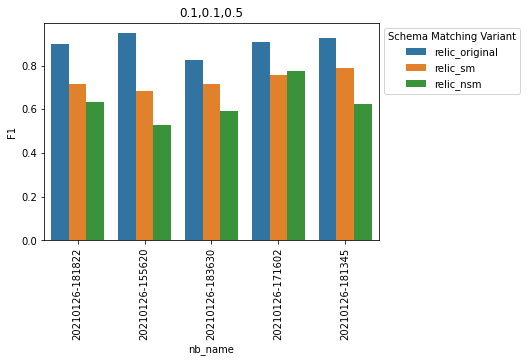

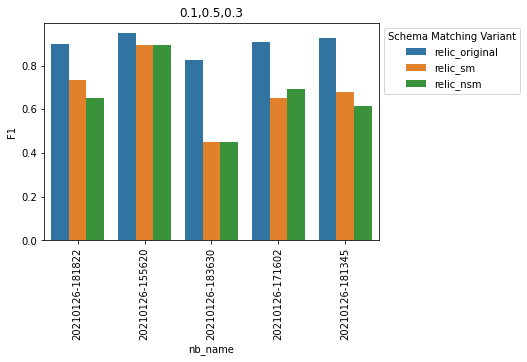

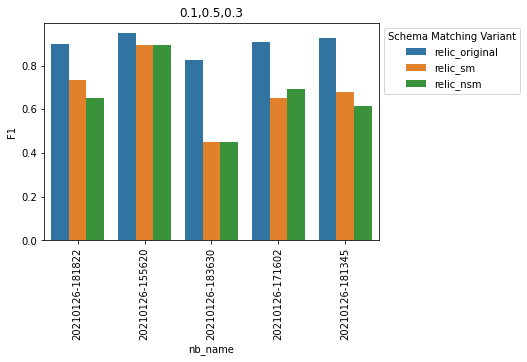

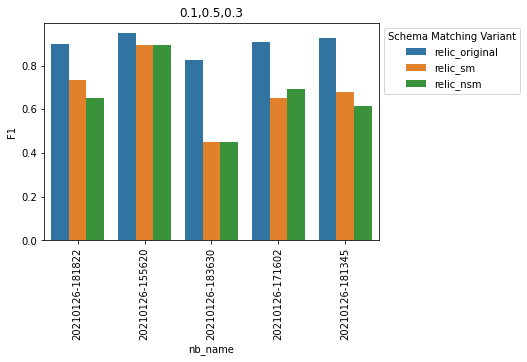

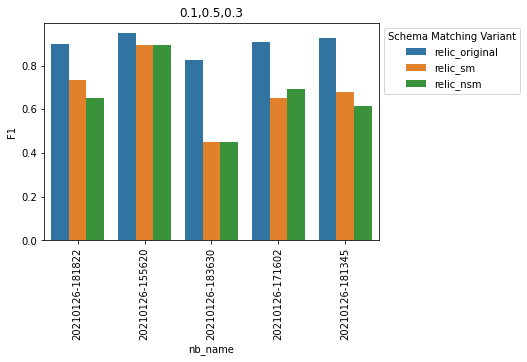

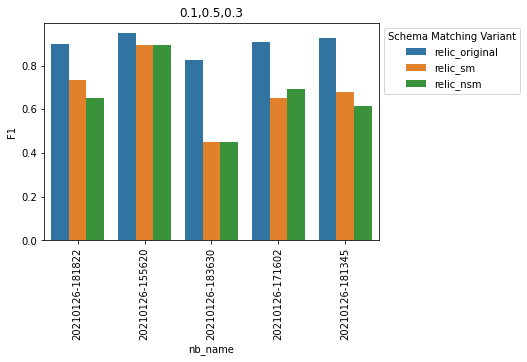

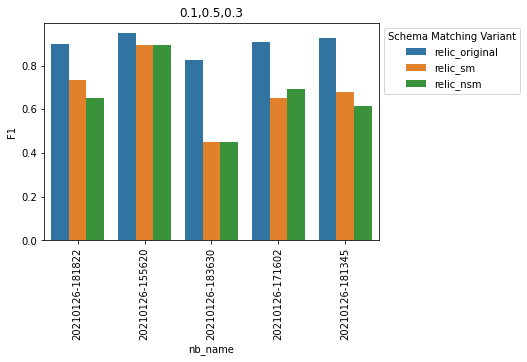

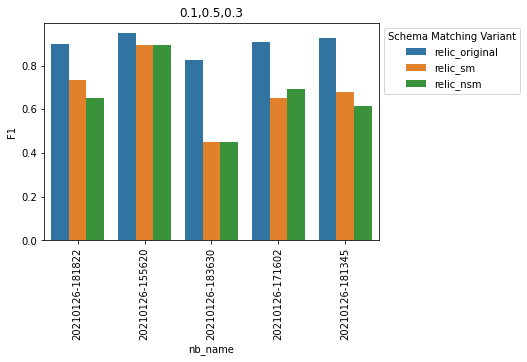

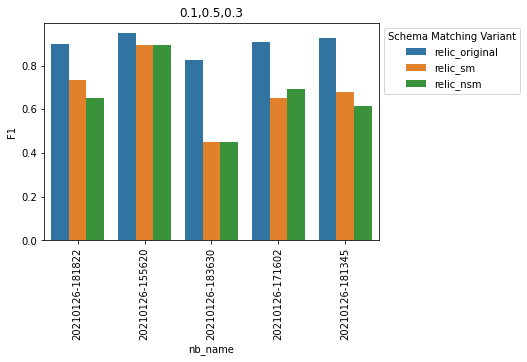

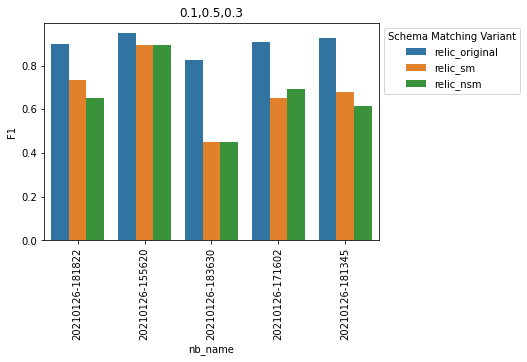

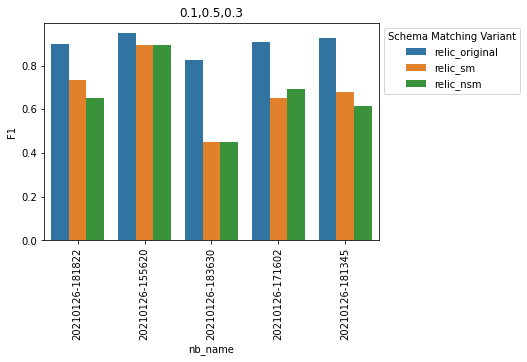

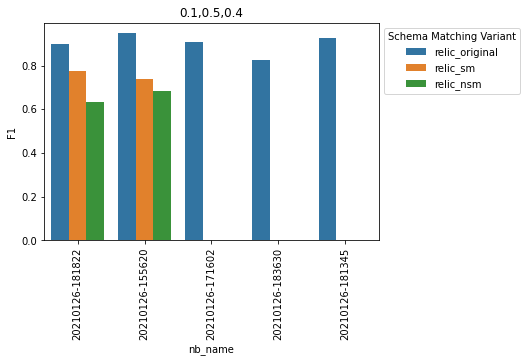

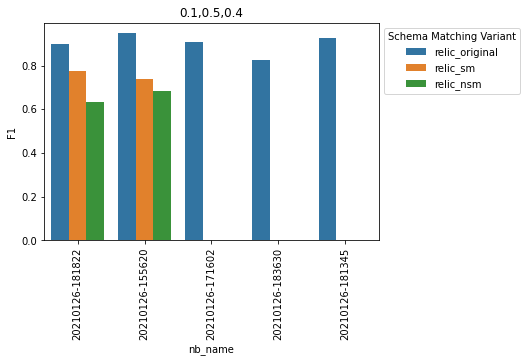

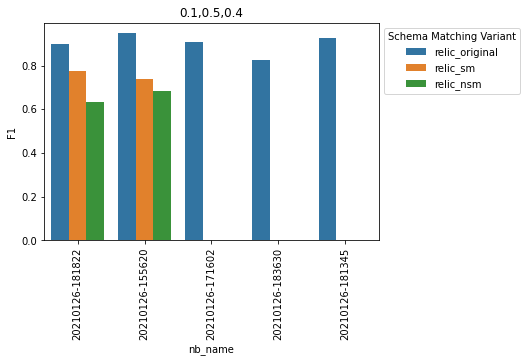

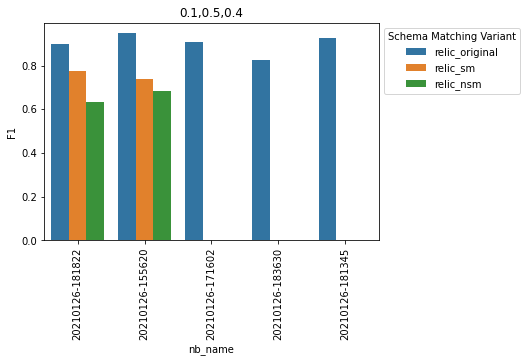

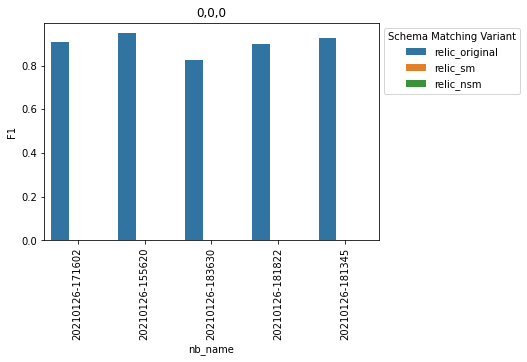

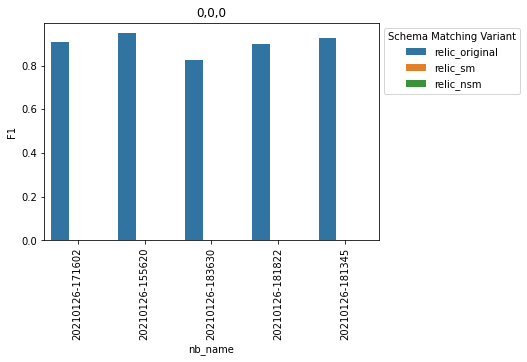

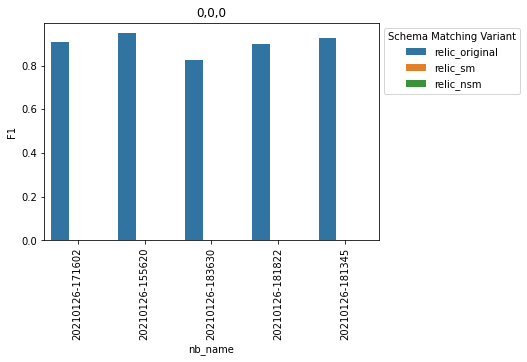

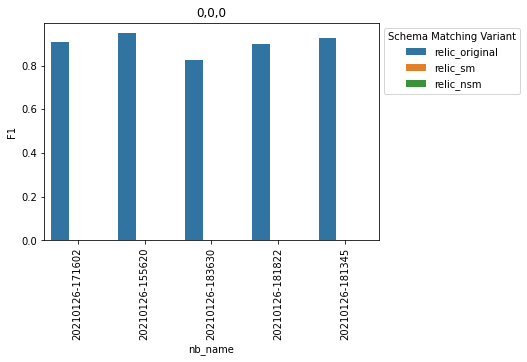

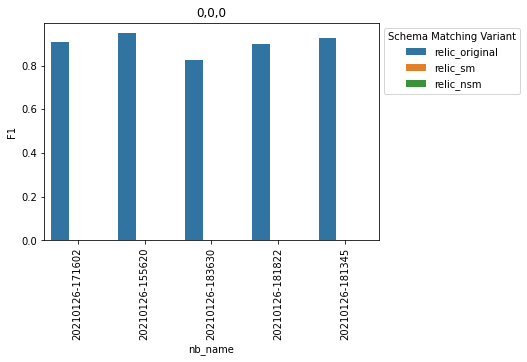

In [71]:
import matplotlib.pyplot as plt
for sm_threshold in combined.config.values:
    #sm_threshold = "0.1,0.1,0.3"
    df_slice = combined.loc[(combined.config==sm_threshold) | (combined.result_type == 'relic_original')]
    sns.barplot(data=df_slice, x='nb_name', y='F1', hue='result_type', hue_order=['relic_original', 'relic_sm', 'relic_nsm'])
    plt.xticks(rotation = 90)
    plt.legend(title='Schema Matching Variant', bbox_to_anchor=(1,1))
    plt.title(sm_threshold)
    plt.show()

In [ ]:

import pickle

pickle.load(open('/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181822/rename_map.pkl','rb'))

In [ ]:
r_df.iloc[0]['correct_edges']

In [ ]:
pd.read_csv('/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181822/artifacts/34.csv')

# Investigate SM issues here

In [8]:
og_r_df = pd.read_csv('/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/20210126-153738/pc2cell+containment+group+join+pivot_relic_result.csv')
og_g_inferred = nx.read_edgelist('/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/20210126-153738/inferred/infered_mst_pc2cell+containment+group+join+pivot.csv')
og_inferred = set(frozenset((u,v)) for u,v,data in og_g_inferred.edges(data=True))
og_inferred


{frozenset({'18.csv', '8.csv'}),
 frozenset({'3.csv', '5.csv'}),
 frozenset({'5.csv', '7.csv'}),
 frozenset({'13.csv', '9.csv'}),
 frozenset({'14.csv', '7.csv'}),
 frozenset({'18.csv', '5.csv'}),
 frozenset({'19.csv', '8.csv'}),
 frozenset({'3.csv', '4.csv'}),
 frozenset({'12.csv', '9.csv'}),
 frozenset({'16.csv', '17.csv'}),
 frozenset({'13.csv', '15.csv'}),
 frozenset({'0.csv', '10.csv'}),
 frozenset({'0.csv', '4.csv'}),
 frozenset({'3.csv', '6.csv'}),
 frozenset({'11.csv', '12.csv'}),
 frozenset({'13.csv', '17.csv'}),
 frozenset({'8.csv', '9.csv'}),
 frozenset({'0.csv', '1.csv'}),
 frozenset({'0.csv', '2.csv'})}

In [2]:
from relic.utils.serialize import build_df_dict_dir

og_df_dict = build_df_dict_dir('/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/20210126-153738/artifacts/')    
og_df_dict.keys()

Loading DFs:   0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['1.csv', '6.csv', '8.csv', '14.csv', '13.csv', '9.csv', '7.csv', '0.csv', '12.csv', '15.csv', '18.csv', '16.csv', '11.csv', '3.csv', '4.csv', '10.csv', '17.csv', '19.csv', '5.csv', '2.csv'])

In [3]:
sm_df_dict = build_df_dict_dir('/mnt/roscoe/data/relic/perturbed/dataset_flat_exact/0.75/0.75/0.5/20210126-153738/artifacts/')    
sm_df_dict.keys()

Loading DFs:   0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['18.csv', '16.csv', '11.csv', '0.csv', '7.csv', '9.csv', '10.csv', '17.csv', '19.csv', '8.csv', '6.csv', '1.csv', '2.csv', '5.csv', '14.csv', '13.csv', '4.csv', '3.csv', '12.csv', '15.csv'])

In [4]:
from relic.distance.ppo import compute_all_ppo
from relic.utils.matching import schema_match_df_combo

compute_all_ppo(og_df_dict['8.csv'], og_df_dict['19.csv']), compute_all_ppo(sm_df_dict['8.csv'], sm_df_dict['19.csv'])

({'jaccard': 0.2736842105263158,
  'containment': 1.0,
  'overlap': 208.0,
  'containment_oneside': 1.0},
 {'jaccard': 0.16421052631578947,
  'containment': 0.75,
  'overlap': 156.0,
  'containment_oneside': 0.75})

In [5]:
sm_tup = ('8.csv','19.csv')
renamed_sm_df_dict, sm_matches = schema_match_df_combo(sm_tup, sm_df_dict)

2022-02-23 23:18:23,650 relic.utils.matching INFO:Renaming 19.csv[month_name] --> src_col_label
2022-02-23 23:18:23,651 relic.utils.matching INFO:Renaming 19.csv[bRndoz_BRwzrcpj5IBehNeY] --> src_col_label


In [6]:
sm_matches

{(('8.csv', 'state'), ('19.csv', 'state')): 0.2582891157916279,
 (('8.csv', 'bothify'), ('19.csv', 'bothify')): 0.2582891157916279,
 (('8.csv', 'pystr'), ('19.csv', 'pystr')): 0.2582891157916279,
 (('8.csv', 'safari'), ('19.csv', 'safari')): 0.2582891157916279,
 (('8.csv', 'paragraph'), ('19.csv', 'paragraph')): 0.2582891157916279,
 (('8.csv', 'safe_email'), ('19.csv', 'safe_email')): 0.2582891157916279,
 (('8.csv', 'lontDln0ma'), ('19.csv', 'month_name')): 0.1955360569591221,
 (('8.csv', 'random_lowercase_letter'),
  ('19.csv', 'bRndoz_BRwzrcpj5IBehNeY')): 0.16748651361390388}

In [7]:
renamed_sm_df_dict['8.csv'].columns, renamed_sm_df_dict['19.csv'].columns

(Index(['state', 'random_lowercase_letter', 'bothify', 'pystr', 'safari',
        'lontDln0ma', 'paragraph', 'safe_email'],
       dtype='object'),
 Index(['state', 'random_lowercase_letter', 'bothify', 'pystr', 'safari',
        'lontDln0ma', 'paragraph', 'safe_email'],
       dtype='object'))

In [9]:
compute_all_ppo(renamed_sm_df_dict['8.csv'], renamed_sm_df_dict['19.csv'])

{'jaccard': 0.2736842105263158,
 'containment': 1.0,
 'overlap': 208.0,
 'containment_oneside': 1.0}

In [12]:
og_df_dict['8.csv'].columns, og_df_dict['19.csv'].columns

(Index(['state', 'random_lowercase_letter', 'bothify', 'pystr', 'safari',
        'month_name', 'paragraph', 'safe_email'],
       dtype='object'),
 Index(['state', 'random_lowercase_letter', 'bothify', 'pystr', 'safari',
        'month_name', 'paragraph', 'safe_email'],
       dtype='object'))

In [13]:
sm_df_dict['8.csv'].columns, sm_df_dict['19.csv'].columns

(Index(['state', 'random_lowercase_letter', 'bothify', 'pystr', 'safari',
        'lontDln0ma', 'paragraph', 'safe_email'],
       dtype='object'),
 Index(['state', 'bRndoz_BRwzrcpj5IBehNeY', 'bothify', 'pystr', 'safari',
        'month_name', 'paragraph', 'safe_email'],
       dtype='object'))

In [14]:
sm_correct_edges = r_df.loc[r_df.nb_name == '20210126-153738'].iloc[0]['correct_edges']
nsm_correct_edges = r_df.loc[r_df.nb_name == '20210126-153738'].iloc[1]['correct_edges']

sm_correct_edges == nsm_correct_edges

True

In [15]:
sm_missing_edges = og_inferred - sm_correct_edges
sm_missing_edges

{frozenset({'18.csv', '8.csv'}),
 frozenset({'3.csv', '4.csv'}),
 frozenset({'11.csv', '12.csv'}),
 frozenset({'12.csv', '9.csv'}),
 frozenset({'13.csv', '9.csv'}),
 frozenset({'19.csv', '8.csv'}),
 frozenset({'5.csv', '7.csv'}),
 frozenset({'16.csv', '17.csv'}),
 frozenset({'13.csv', '17.csv'}),
 frozenset({'14.csv', '7.csv'}),
 frozenset({'0.csv', '4.csv'}),
 frozenset({'3.csv', '6.csv'})}

In [16]:
[print(u,v,og_g_inferred[u][v]) for u,v in sm_missing_edges]

8.csv 18.csv {'weight': 0.95, 'num': 5, 'type': 'cell'}
4.csv 3.csv {'weight': 1.0, 'num': 13, 'type': 'join'}
12.csv 11.csv {'weight': 1.0, 'num': 8, 'type': 'join'}
12.csv 9.csv {'weight': 1.0, 'num': 9, 'type': 'join'}
13.csv 9.csv {'weight': 0.875, 'num': 17, 'type': 'cell'}
8.csv 19.csv {'weight': 0.2736842105263158, 'num': 7, 'type': 'cell'}
5.csv 7.csv {'weight': 0.95, 'num': 6, 'type': 'cell'}
16.csv 17.csv {'weight': 1.0, 'num': 11, 'type': 'join'}
13.csv 17.csv {'weight': 1.0, 'num': 10, 'type': 'join'}
14.csv 7.csv {'weight': 0.9988304093567252, 'num': 2, 'type': 'cell'}
4.csv 0.csv {'weight': 1.0, 'num': 12, 'type': 'join'}
3.csv 6.csv {'weight': 0.9988888888888889, 'num': 0, 'type': 'cell'}


[None, None, None, None, None, None, None, None, None, None, None, None]

In [156]:
sm_correct_edges - og_inferred

set()

In [92]:
pd.read_csv('dataset_flat_exact_config.csv', index_col=0)

,nb_name,artifacts3
0,20210126-153738,"20,100,10"
1,20210126-153738,"20,100,10"
2,20210126-153738,"20,100,10"
3,20210126-153738,"20,100,10"
4,20210126-153738,"20,100,10"
...,...,...
990,20210126-164043,"20,50000,20"
991,20210126-164043,"20,50000,20"
992,20210126-164043,"20,50000,20"
993,20210126-164043,"20,50000,20"


In [74]:
list(range(10))
np.random.choice(np.random.exponential(1.0,size=10)

array([0.1274332 , 1.38277785, 0.97689314, 0.368171  , 0.67810571,
       0.55631672, 0.36111409, 0.07178421, 0.324867  , 0.84151175])